### Initial setting to mount the drive and the data building

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/My Drive/colab_notebooks')
print("Directory changed")

Directory changed


In [3]:
!pwd
!ls

/content/drive/My Drive/colab_notebooks
PlantVillage


In [4]:
!pwd

/content/drive/My Drive/colab_notebooks


# Coding Begins !!!!

In [4]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
print("-> library installed")

-> library installed


In [5]:
### some constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
SEED = 12
INPUT_SHAPE = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
len(dataset)

68

68 batches

In [10]:
for image_batch , label_batch in dataset.take(1):
  print(image_batch[0])
  print(label_batch)

tf.Tensor(
[[[143. 133. 141.]
  [145. 135. 143.]
  [148. 138. 146.]
  ...
  [120. 109. 113.]
  [122. 111. 115.]
  [126. 115. 119.]]

 [[159. 149. 157.]
  [155. 145. 153.]
  [149. 139. 147.]
  ...
  [126. 115. 119.]
  [126. 115. 119.]
  [123. 112. 116.]]

 [[151. 141. 149.]
  [152. 142. 150.]
  [152. 142. 150.]
  ...
  [134. 123. 127.]
  [132. 121. 125.]
  [122. 111. 115.]]

 ...

 [[174. 166. 164.]
  [175. 167. 165.]
  [175. 167. 165.]
  ...
  [137. 125. 125.]
  [152. 140. 140.]
  [147. 135. 135.]]

 [[172. 164. 162.]
  [173. 165. 163.]
  [175. 167. 165.]
  ...
  [141. 129. 129.]
  [143. 131. 131.]
  [141. 129. 129.]]

 [[163. 155. 153.]
  [165. 157. 155.]
  [167. 159. 157.]
  ...
  [152. 140. 140.]
  [141. 129. 129.]
  [143. 131. 131.]]], shape=(256, 256, 3), dtype=float32)
tf.Tensor([1 1 0 1 0 1 1 0 0 0 0 0 1 2 1 0 2 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1], shape=(32,), dtype=int32)


In [11]:
for image_batch , label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1]


##### 32 = images (1 batch)
##### 256,256 = pixel shape
##### 3 = rgb channels
##### 0,1,2 = class labels

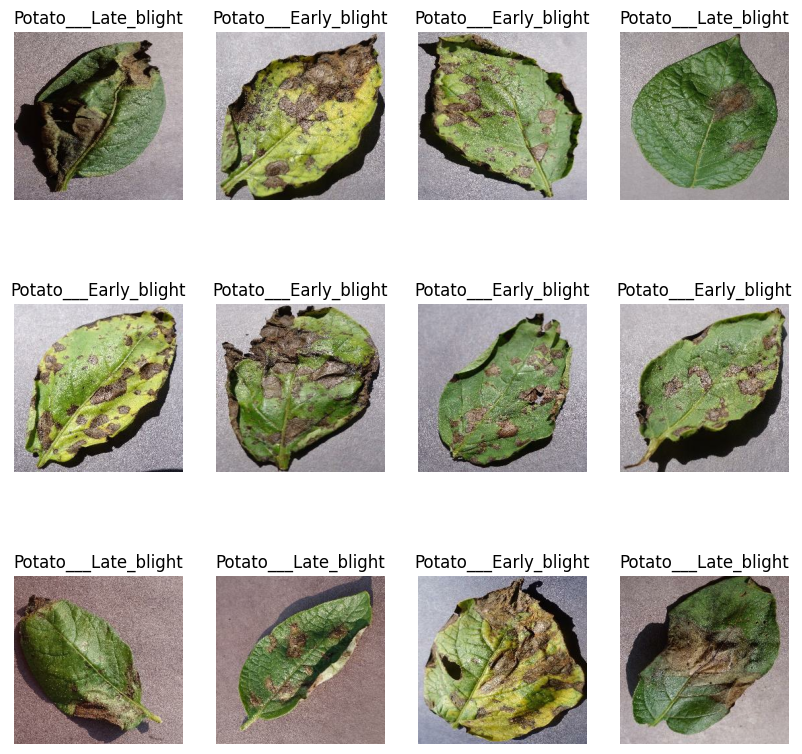

In [12]:
### visualize the images
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
  for i in range(12):  ## displaying first 12 images
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

##### spliting into train_test_split

In [ ]:
train_size = int(len(dataset) * 0.8)
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
print(f"train_ds : {len(train_ds)}")
print(f"test_ds : {len(test_ds)}")
print(f"dataset len  : {len(dataset)}")

train_ds : 54
test_ds : 14
dataset len  : 68


In [ ]:
val_size = int(len(dataset)*0.1)
val_ds = dataset.take(val_size)
test_ds = test_ds.skip(6)

In [8]:
def get_dataset_partitions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  if shuffle:
    ds = ds.shuffle(shuffle_size,SEED)
  ds_size = len(ds)
  train_size = int(ds_size*train_split)
  val_size = int(ds_size*val_split)
  train_ds = dataset.take(train_size)
  val_ds =  dataset.skip(train_size).take(val_size)
  test_ds = dataset.skip(train_size).skip(val_size)
  return train_ds,test_ds,val_ds

In [9]:
train_ds,test_ds,val_ds = get_dataset_partitions(dataset)

In [10]:
print(f"dataset len  : {len(dataset)}")
print(f"train_ds : {len(train_ds)}")
print(f"test_ds : {len(test_ds)}")
print(f"val_ds : {len(val_ds)}")

dataset len  : 68
train_ds : 54
test_ds : 8
val_ds : 6


#### setting to GPU compatible while loading and saving the data in cache with shuffle

In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

#### Buliding the Sequential model for resizing and rescaling for the user image

In [12]:
resize_rescale_layer = tf.keras.models.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255),

])

#### Buliding the Sequential model for data augmentation to make model more robust

In [13]:
data_augmentation_layer = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),

])

In [14]:
INPUT_SHAPE

(32, 256, 256, 3)

In [15]:
### building the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    resize_rescale_layer,
    data_augmentation_layer,
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(3,activation='softmax')
])


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.build()

In [18]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 121s 388ms/step - accuracy: 0.4974 - loss: 0.9394 - val_accuracy: 0.7031 - val_loss: 0.9130
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6535 - loss: 0.7811 - val_accuracy: 0.7500 - val_loss: 0.5760
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7758 - loss: 0.4836 - val_accuracy: 0.8698 - val_loss: 0.3488
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8391 - loss: 0.3917 - val_accuracy: 0.8750 - val_loss: 0.3228
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8803 - loss: 0.3043 - val_accuracy: 0.8594 - val_loss: 0.4260
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8696 - loss: 0.3058 - val_accuracy: 0.9375 - val_loss: 0.1822
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9239 - loss: 0.2178 - val_accuracy: 0.9167 - val_loss: 0.2394
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9346 - loss: 0.1840 - val_accuracy: 0.8646 

In [20]:
model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9862 - loss: 0.0847


[0.04538358747959137, 0.9913793206214905]

Text(0.5, 1.0, 'Training and validation Loss')

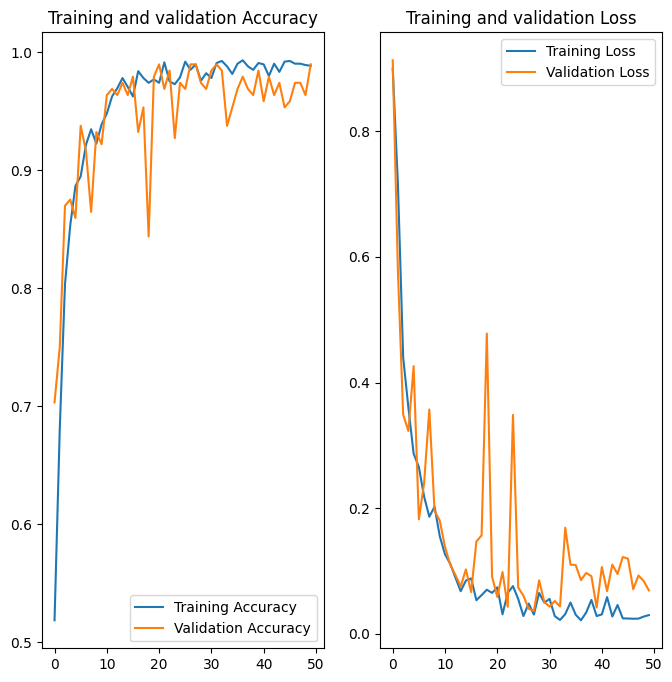

In [26]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),history.history['accuracy'],label='Training Accuracy')
plt.plot(range(EPOCHS),history.history['val_accuracy'],label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),history.history['loss'],label='Training Loss')
plt.plot(range(EPOCHS),history.history['val_loss'],label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and validation Loss")

In [27]:
import numpy as np

Predict the first image
actual label:  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
predicted label :  Potato___Late_blight
confidence :  1.0


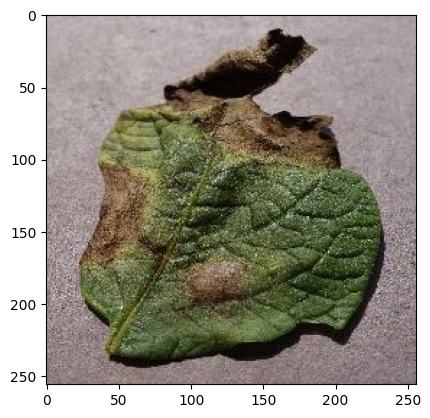

In [32]:
for image_batch , label_batch in dataset.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()
  print("Predict the first image")
  plt.imshow(first_image)
  print("actual label: ",class_names[first_label]),
  batch_prediction = model.predict(image_batch)
  print("predicted label : ",class_names[np.argmax(batch_prediction[0])])
  print("confidence : ",batch_prediction[0][np.argmax(batch_prediction[0])])

In [33]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = np.expand_dims(img_array,axis=0)
  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = np.round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


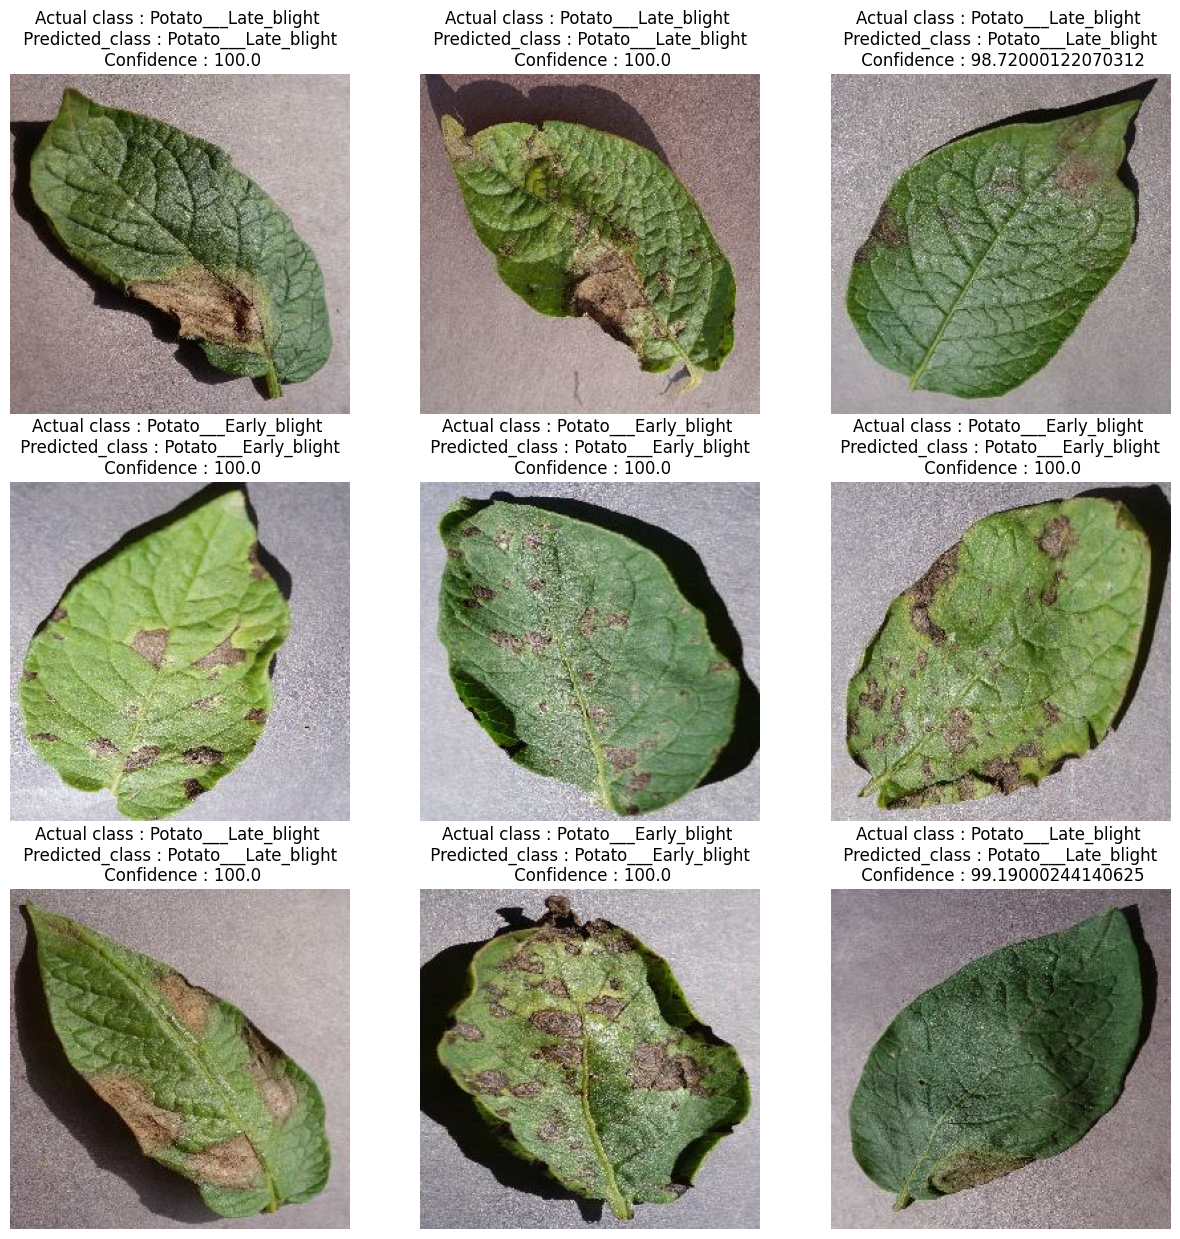

In [34]:
plt.figure(figsize=(15,15))
for image_batch , label_batch in dataset.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    predicted_class,confidence = predict(model,image_batch[i].numpy())
    actual_class = class_names[label_batch[i]]
    plt.title(
        f"Actual class : {actual_class} \n Predicted_class : {predicted_class} \n Confidence : {confidence}"
    )
    plt.axis("off")

In [35]:
!cwd

/bin/bash: line 1: cwd: command not found


In [36]:
!pwd
!ls

/content/drive/MyDrive/colab_notebooks
PlantVillage


In [37]:
!mkdir("models")

/bin/bash: -c: line 1: syntax error near unexpected token `"models"'
/bin/bash: -c: line 1: `mkdir("models")'


In [38]:
curr_dir = "/content/drive/MyDrive/colab_notebooks"
model_dir = "models"
path = os.path.join(curr_dir,model_dir)
os.mkdir(path)


In [39]:
!ls

models	PlantVillage


In [41]:
model_version = 1
model.export(f"/content/drive/My Drive/colab_notebooks/models/version_{model_version}")


Saved artifact at '/content/drive/My Drive/colab_notebooks/models/version_1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135402300586896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402276115408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402276120016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402276120784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402276120976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402276121168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402276122128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402276121360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402276122512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135402276122320: TensorSpec(shape=(), dtype=